<a href="https://colab.research.google.com/github/michaeltmk/IBM-Data-Science-Capstone-Project/blob/master/capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Analysis of population and Venue distribution in Hong Kong


## 1. Introduction
Hong Kong is a highly developed territory, which ranks fourth on the UN Human Development Index. With over 7.4 million people of various nationalities in a 1,104-square-kilometre (426 sq. mi) territory, Hong Kong is one of the most densely populated places in the world. The dense space also led to a developed transportation network with public transport rates exceeding 90%. Hong Kong is ranked third in the Global Financial Centre Index, behind New York City and London. As it is a very important international financial, business services and recognized centre in the world, talents, and investors from worldwide are being concentrated in this place.

From the businessman's point of view, which location is the best for the new business is the key question. A retail store should be opened at a location with a high population but less similar varieties in the surrounding; an office should be located somewhere easy to go ( which is not a problem in HK) and surrounded by restaurant, but also with a reasonable price of rent. Keeping the above things in mind that it is very difficult for an individual to find such a place in such a big city and gather this much information. 

This report will visualize the population and venue information through a map and conclude on some potential locations for different venues.

##2. Data


###2.1 Data Sources
For this report, I followed the region(neighbourhood) definition in Hong Kong population distribution data, separating Hong Kong into 376 neighbourhoods in 18 Districts. The sources of data are listed as follows:

*   Hong Kong neighbourhoods’ names list: defined in Hong Kong population distribution data
*   Hong Kong population data: https://www.bycensus2016.gov.hk/en/bc-own_tbl.html
*   Neighbourhoods’ Geographic Coordinates: Nominatim API
*   Venues data: Foursquare API
*   District boundary geojson: https://data.gov.hk/en-data/dataset/hk-had-json1-hong-kong-administrative-boundaries/resource/5b64f6ae-8827-444c-a092-b227112ab3ab

The Hong Kong population data was downloaded from the Hong Kong government website, and the neighbourhoods’ definition of this report followed which in this file. The geographic coordinates of each neighbourhood were found by Nominatim API.  A Foursquare API GET request is sent in order to acquire the surrounding venues that are within a radius of 1000m.


In [0]:
import numpy as np
import pandas as pd
import folium
import requests
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import json
import time
try:
  import geopandas as gpd
except:
  !pip install geopandas
  import geopandas as gpd
ACCESS_TOKEN_ = 'IZRYG0IUU5CDRO23XUINJGIMGZUDZMHWYLGEOGOLO4WQOCWG'
try:
  import geocoder
except:
  !pip install geocoder
  import geocoder

try:
  from geopy.geocoders import GoogleV3
  from geopy.geocoders import Nominatim
except:
  !pip install geopy
  from geopy.geocoders import GoogleV3
  from geopy.geocoders import Nominatim

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


####Poplution data

In [3]:
poplution_df = pd.read_csv('/content/drive/My Drive/capstone project/population_per_18_district.csv')
poplution_df.columns = ['neighborhood', 'population']
poplution_df

,neighborhood,population
0,Central and Western,243266
1,Wan Chai,180123
2,Eastern,555034
3,Southern,274994
4,Yau Tsim Mong,342970
5,Sham Shui Po,405869
6,Kowloon City,418732
7,Wong Tai Sin,425235
8,Kwun Tong,648541
9,Kwai Tsing,520572


####Neighborhood data

In [4]:
pop432_df = pd.read_csv('/content/drive/My Drive/capstone project/Population_by_District_Council.csv')
pop432_df.columns = ['neighborhood', 'population']
neighborhood_df = pop432_df['neighborhood'].str.split(' - ', expand = True)
neighborhood_df.columns = ['district', 'neighborhood']
neighborhood_df

,district,neighborhood
0,Central and Western,Chung Wan
1,Central and Western,Mid Levels East
2,Central and Western,Castle Road
3,Central and Western,Peak
4,Central and Western,University
...,...,...
426,Islands,Discovery Bay
427,Islands,Peng Chau and Hei Ling Chau
428,Islands,Lamma and Po Toi
429,Islands,Cheung Chau South


###2.2 Data cleaning
The list of neighbourhoods of each district needs to be cleaned and modified. The principle of defining neighbourhoods in the raw data set is partially  based on the population, which is not useful in this project. This lead to 3 problems: some of the neighbourhoods like ‘Tsim Sha Trui  East’ & ‘Tsim Sha Trui  West’ which are actually the same; some are too near to each other; some cannot find a single geographic coordinates. 
So, first of all, for the names of neighbourhood having any of the words at the end: ‘North, East, South, West, Upper, Lower, I, II’ , I deleted that word.
Secondly, I manually checked every neighbourhood, if any of them are too near to each other or hard to find a geographic coordinates using Nominatim API, I manually assigned a location. 
Thirdly, if any one of the neighbourhood cannot find the coordinates using Nominatim API, then the district coordinates will be used, this can ensure that every neighbourhood have coordinates being assigned.

The categories of venues need to do modification manually, because some of the categories are not well enough, such as 'shops'( this is too general), or 'Food Court' (this should be classified as 'food').


In [5]:
#data cleaning
def data_cleaning(word):
  for key in [' North',' South',' West',' East', ' Central', 'I', 'II']:
    try:
      idx = word.index(key)
      return word[:idx]
    except:
      continue

  for key2 in ['Upper', 'Lower']:
    try:
      idx = word.index(key2)+6
      return word[idx:]
    except:
      continue
  return word

neighborhood_df['neighborhood'] = neighborhood_df['neighborhood'].apply(data_cleaning)
neighborhood_df.drop_duplicates(inplace=True)

to_replace = ['Chung Wan', 'University','Yan Lam','King Yee','Yiu Tung',
              'Tai Fat Hau','Yue Wan','Kai Hiu',
              "East Tsim Sha Tsui and King's Park",
              
              ]
value = ['Central','HKU','Siu Sai Wan','Siu Sai Wan','Yiu Tung Estate',
         'Southorn','Eastern','Eastern',
         "King's Park",
         ]
neighborhood_df.replace(to_replace= to_replace, value= value, inplace=True)
neighborhood_df.drop_duplicates(inplace=True)
neighborhood_df.reset_index(inplace=True)
neighborhood_df

,index,district,neighborhood
0,0,Central and Western,Central
1,1,Central and Western,Mid Levels
2,2,Central and Western,Castle Road
3,3,Central and Western,Peak
4,4,Central and Western,HKU
...,...,...,...
371,424,Islands,Tung Chung
372,426,Islands,Discovery Bay
373,427,Islands,Peng Chau and Hei Ling Chau
374,428,Islands,Lamma and Po Toi


####Geo-coordinate
The dataset is split into 8 subsets with 50 rows each, to avoid connection error in GET requests.

In [0]:
#extract neighborhood coordinate
def get_coor(df):
  lat_lng_coords = None
  count = 0
  while(lat_lng_coords is None):
    geolocator = Nominatim(user_agent="specify_your_app_name_here")
    if count >=1:
      search_key = f'{df.district} District,Hong Kong,China'
    else:
      search_key = f'{df.neighborhood},{df.district} District,Hong Kong,China'
    lat_lng_coords = geolocator.geocode(search_key)
    try:
      print(lat_lng_coords.address,search_key)
    except:
      print(f'try {search_key} again')
    count +=1
  df['latitude'] , df['longitude'] = lat_lng_coords.latitude, lat_lng_coords.longitude
  return df

In [0]:
#spilt into 8 df avoid error
dfs = [neighborhood_df.iloc[x:x+50,:] for x in [0,50,100,150,200,250,300,350]]

In [8]:
df_x = 0
time.sleep(60)
dfs[df_x] = dfs[df_x].apply(get_coor, axis = 1)

中環 Central, 香港 Hong Kong, 中西區 Central and Western District, 香港島 Hong Kong Island, 香港 Hong Kong, China 中国 Central,Central and Western District,Hong Kong,China
中環 Central, 香港 Hong Kong, 中西區 Central and Western District, 香港島 Hong Kong Island, 香港 Hong Kong, China 中国 Central,Central and Western District,Hong Kong,China
半山區 Mid-levels, 香港 Hong Kong, 中西區 Central and Western District, 香港島 Hong Kong Island, 香港 Hong Kong, China 中国 Mid Levels,Central and Western District,Hong Kong,China
衛城道 Castle Road, 西半山 Mid-Levels West, 半山區 Mid-levels, 香港 Hong Kong, 中西區 Central and Western District, 香港島 Hong Kong Island, 香港 Hong Kong, China 中国 Castle Road,Central and Western District,Hong Kong,China
山頂 The Peak, 香港 Hong Kong, 中西區 Central and Western District, 香港島 Hong Kong Island, 香港 Hong Kong, China 中国 Peak,Central and Western District,Hong Kong,China
香港大學 HKU, 79C, 薄扶林道 Pok Fu Lam Road, 西半山 Mid-Levels West, 石塘咀 Shek Tong Tsui, 西環 Sai Wan, 中西區 Central and Western District, 香港島 Hong Kong Island, 香港 Hong Kong,

In [9]:
df_x = 1
time.sleep(60)
dfs[df_x] = dfs[df_x].apply(get_coor, axis = 1)

興東邨 Hing Tung Estate, 西灣河 Sai Wan Ho, 阿公岩村 A Kung Ngam Village, 東區 Eastern District, 香港島 Hong Kong Island, 香港 Hong Kong, China 中国 Hing Tung,Eastern District,Hong Kong,China
興東邨 Hing Tung Estate, 西灣河 Sai Wan Ho, 阿公岩村 A Kung Ngam Village, 東區 Eastern District, 香港島 Hong Kong Island, 香港 Hong Kong, China 中国 Hing Tung,Eastern District,Hong Kong,China
西灣河 Sai Wan Ho, 111, 筲箕灣道 Shau Kei Wan Road, 愛秩序灣 Aldrich Bay, 西灣河 Sai Wan Ho, 阿公岩村 A Kung Ngam Village, 東區 Eastern District, 香港島 Hong Kong Island, 香港 Hong Kong, China 中国 Sai Wan Ho,Eastern District,Hong Kong,China
耀東邨 Yiu Tung Estate, 筲箕灣 Shau Kei Wan, 阿公岩村 A Kung Ngam Village, 東區 Eastern District, 香港島 Hong Kong Island, 香港 Hong Kong, China 中国 Yiu Tung Estate,Eastern District,Hong Kong,China
興民邨 Hing Man Estate, 柴灣 Chai Wan, 阿公岩村 A Kung Ngam Village, 東區 Eastern District, 香港島 Hong Kong Island, 香港 Hong Kong, China 中国 Hing Man,Eastern District,Hong Kong,China
康樂大廈 Hong Lok Building, 北角 North Point, 香港 Hong Kong, 東區 Eastern District, 香港島 Hong Kong Is

In [10]:
df_x = 2
time.sleep(60)
dfs[df_x] = dfs[df_x].apply(get_coor, axis = 1)

常樂邨 Sheung Lok Estate, 何文田 Ho Man Tin, 九龍城區 Kowloon City District, 九龍 Kowloon, 香港 Hong Kong, China 中国 Lok Man,Kowloon City District,Hong Kong,China
常樂邨 Sheung Lok Estate, 何文田 Ho Man Tin, 九龍城區 Kowloon City District, 九龍 Kowloon, 香港 Hong Kong, China 中国 Lok Man,Kowloon City District,Hong Kong,China
常樂邨 Sheung Lok Estate, 何文田 Ho Man Tin, 九龍城區 Kowloon City District, 九龍 Kowloon, 香港 Hong Kong, China 中国 Sheung Lok,Kowloon City District,Hong Kong,China
何文田 Ho Man Tin, 九龍城區 Kowloon City District, 九龍 Kowloon, 香港 Hong Kong, China 中国 Ho Man Tin,Kowloon City District,Hong Kong,China
加多利山 Kadoorie Hill, 九龍城區 Kowloon City District, 九龍 Kowloon, 香港 Hong Kong, 682, China 中国 Kadoorie,Kowloon City District,Hong Kong,China
太子道東 Prince Edward Road East, 啟德 Kai Tak, 九龍城區 Kowloon City District, 九龍 Kowloon, 香港 Hong Kong, China 中国 Prince,Kowloon City District,Hong Kong,China
九龍塘 Kowloon Tong, 九龍城區 Kowloon City District, 九龍 Kowloon, 香港 Hong Kong, China 中国 Kowloon Tong,Kowloon City District,Hong Kong,China
龍城大樓 Lun

In [11]:
df_x = 3
time.sleep(60)
dfs[df_x] = dfs[df_x].apply(get_coor, axis = 1)

秀茂坪 Sau Mau Ping, 井欄樹 Tseng Lan Shue, 觀塘區 Kwun Tong District, 九龍 Kowloon, 香港 Hong Kong, China 中国 Sau Mau Ping,Kwun Tong District,Hong Kong,China
秀茂坪 Sau Mau Ping, 井欄樹 Tseng Lan Shue, 觀塘區 Kwun Tong District, 九龍 Kowloon, 香港 Hong Kong, China 中国 Sau Mau Ping,Kwun Tong District,Hong Kong,China
曉麗苑 Hiu Lai Court, 秀茂坪 Sau Mau Ping, 井欄樹 Tseng Lan Shue, 觀塘區 Kwun Tong District, 九龍 Kowloon, 香港 Hong Kong, China 中国 Hiu Lai,Kwun Tong District,Hong Kong,China
興田 Hing Tin, 連德道 Lin Tak Road, 長龍田 Cheung Lung Tin, 藍田 Lam Tin, 將軍澳 Tseung Kwan O, 觀塘區 Kwun Tong District, 九龍 Kowloon, 香港 Hong Kong, China 中国 Hing Tin,Kwun Tong District,Hong Kong,China
藍田 Lam Tin, 鯉魚門道 Lei Yue Mun Road, 匯景花園 Sceneway Garden, 晒草灣 Sai Tso Wan, 香港 Hong Kong, 觀塘區 Kwun Tong District, 九龍 Kowloon, 香港 Hong Kong, China 中国 Lam Tin,Kwun Tong District,Hong Kong,China
藍田(廣田邨) Lam Tin (Kwong Tin Estate), 碧雲道 Pik Wan Road, 德田邨 Tak Tin Estate, 藍田 Lam Tin, 將軍澳 Tseung Kwan O, 觀塘區 Kwun Tong District, 九龍 Kowloon, 香港 Hong Kong, China 中国 Kwong Tak,K

In [12]:
df_x = 4
time.sleep(60)
dfs[df_x] = dfs[df_x].apply(get_coor, axis = 1)

福來邨 Fuk Loi Estate, 木棉下村 Muk Min Ha Tsuen, 荃灣 Tsuen Wan, 荃灣區 Tsuen Wan District, 新界 New Territories, 香港 Hong Kong, China 中国 Fuk Loi,Tsuen Wan District,Hong Kong,China
福來邨 Fuk Loi Estate, 木棉下村 Muk Min Ha Tsuen, 荃灣 Tsuen Wan, 荃灣區 Tsuen Wan District, 新界 New Territories, 香港 Hong Kong, China 中国 Fuk Loi,Tsuen Wan District,Hong Kong,China
398, 愉景新城 Discovery Park, 光板田村 Kwong Pan Tin Village, 荃灣 Tsuen Wan, 荃灣區 Tsuen Wan District, 新界 New Territories, 香港 Hong Kong, China 中国 Discovery Park,Tsuen Wan District,Hong Kong,China
荃灣中心 Tsuen Wan Centre, 光板田村 Kwong Pan Tin Village, 荃灣 Tsuen Wan, 荃灣區 Tsuen Wan District, 新界 New Territories, 香港 Hong Kong, China 中国 Tsuen Wan Centre,Tsuen Wan District,Hong Kong,China
荃威花園 Allway Gardens, 柴灣角 Chai Wan Kok, 荃灣 Tsuen Wan, 荃灣區 Tsuen Wan District, 新界 New Territories, 香港 Hong Kong, China 中国 Allway,Tsuen Wan District,Hong Kong,China
福來邨 Fuk Loi Estate, 木棉下村 Muk Min Ha Tsuen, 荃灣 Tsuen Wan, 荃灣區 Tsuen Wan District, 新界 New Territories, 香港 Hong Kong, China 中国 Lai To,Tsue

In [13]:
df_x = 5
time.sleep(60)
dfs[df_x] = dfs[df_x].apply(get_coor, axis = 1)

廈村 Ha Tsuen, 元朗區 Yuen Long District, 新界 New Territories, 香港 Hong Kong, DD117 154, China 中国 Ha Tsuen,Yuen Long District,Hong Kong,China
廈村 Ha Tsuen, 元朗區 Yuen Long District, 新界 New Territories, 香港 Hong Kong, DD117 154, China 中国 Ha Tsuen,Yuen Long District,Hong Kong,China
天榮 Tin Wing, 天城路 Tin Shing Road, 東頭村 Tung Tau Tsuen, 沙江圍 Sha Kong Wai, 天水圍 Tin Shui Wai, 元朗區 Yuen Long District, 新界 New Territories, 香港 Hong Kong, China 中国 Tin Shing,Yuen Long District,Hong Kong,China
try Shui Oi,Yuen Long District,Hong Kong,China again
元朗區 Yuen Long District, 新界 New Territories, 香港 Hong Kong, China 中国 Yuen Long District,Hong Kong,China
try Shui Wah,Yuen Long District,Hong Kong,China again
元朗區 Yuen Long District, 新界 New Territories, 香港 Hong Kong, China 中国 Yuen Long District,Hong Kong,China
try Chung Wah,Yuen Long District,Hong Kong,China again
元朗區 Yuen Long District, 新界 New Territories, 香港 Hong Kong, China 中国 Yuen Long District,Hong Kong,China
天悅 Tin Yuet, 天華路 Tin Wah Road, 東頭村 Tung Tau Tsuen, 沙江圍 Sha Ko

In [14]:
df_x = 6
time.sleep(60)
dfs[df_x] = dfs[df_x].apply(get_coor, axis = 1)

try Po Nga,Tai Po District,Hong Kong,China again
大埔區 Tai Po District, 新界 New Territories, 香港 Hong Kong, China 中国 Tai Po District,Hong Kong,China
try Po Nga,Tai Po District,Hong Kong,China again
大埔區 Tai Po District, 新界 New Territories, 香港 Hong Kong, China 中国 Tai Po District,Hong Kong,China
太和 Tai Wo, 啟和路 Kai Wo Road, 太和邨 Tai Wo Estate, 大埔舊墟 Tai Po Old Market, 大埔頭 Tai Po Tau, 大埔區 Tai Po District, 新界 New Territories, 香港 Hong Kong, China 中国 Tai Wo,Tai Po District,Hong Kong,China
try Old Market and Serenity,Tai Po District,Hong Kong,China again
大埔區 Tai Po District, 新界 New Territories, 香港 Hong Kong, China 中国 Tai Po District,Hong Kong,China
康樂園 Hong Lok Yuen, 泰亨新圍 Tai Hang San Wai, 大埔頭 Tai Po Tau, 大埔區 Tai Po District, 新界 New Territories, 香港 Hong Kong, China 中国 Hong Lok Yuen,Tai Po District,Hong Kong,China
船灣 Shuen Wan, 汀角 Ting Kok, 大埔區 Tai Po District, 新界 New Territories, 香港 Hong Kong, DD29 375, China 中国 Shuen Wan,Tai Po District,Hong Kong,China
try Sai Kung,Tai Po District,Hong Kong,China ag

In [15]:
df_x = 7
time.sleep(60)
dfs[df_x] = dfs[df_x].apply(get_coor, axis = 1)

善明邨 Shin Ming Estate, 調景嶺 Tiu Keng Leng, 將軍澳 Tseung Kwan O, 西貢區 Sai Kung District, 新界 New Territories, 香港 Hong Kong, China 中国 Do Shin,Sai Kung District,Hong Kong,China
善明邨 Shin Ming Estate, 調景嶺 Tiu Keng Leng, 將軍澳 Tseung Kwan O, 西貢區 Sai Kung District, 新界 New Territories, 香港 Hong Kong, China 中国 Do Shin,Sai Kung District,Hong Kong,China
健明邨 Kin Ming Estate, 調景嶺 Tiu Keng Leng, 將軍澳 Tseung Kwan O, 西貢區 Sai Kung District, 新界 New Territories, 香港 Hong Kong, China 中国 Kin Ming,Sai Kung District,Hong Kong,China
建采樓 Kin Choi Tower, 勤學里 Kan Hok Lane, 健明邨 Kin Ming Estate, 調景嶺 Tiu Keng Leng, 將軍澳 Tseung Kwan O, 西貢區 Sai Kung District, 新界 New Territories, 香港 Hong Kong, China 中国 Choi Kin,Sai Kung District,Hong Kong,China
中國聯通 China Unicom, 佛堂洲 Fat Tong Chau, 香港 Hong Kong, 西貢區 Sai Kung District, 新界 New Territories, 香港 Hong Kong, China 中国 O Tong,Sai Kung District,Hong Kong,China
將軍澳 Junk Bay, 衛奕信徑 Wilson Trail, 長龍田 Cheung Lung Tin, 馬游塘 Ma Yau Tong, 將軍澳 Tseung Kwan O, 西貢區 Sai Kung District, 新界 New Territories

In [16]:
neighborhood_df = pd.concat(dfs)
neighborhood_df.drop('index',axis =1,inplace=True)
neighborhood_df

,district,neighborhood,latitude,longitude
0,Central and Western,Central,22.281322,114.160258
1,Central and Western,Mid Levels,22.282405,114.145809
2,Central and Western,Castle Road,22.281680,114.147808
3,Central and Western,Peak,22.269917,114.150667
4,Central and Western,HKU,22.283976,114.135507
...,...,...,...,...
371,Islands,Tung Chung,22.289257,113.941491
372,Islands,Discovery Bay,22.297369,114.016528
373,Islands,Peng Chau and Hei Ling Chau,22.230076,113.986785
374,Islands,Lamma and Po Toi,22.230076,113.986785


##3. Methodology


###3.1 Exploratory Data Analysis

As the geojson file contain only 18 districts’ boundaries are contained, I cannot draw all 430 neighbourhoods’ regions on the map. So, assuming the population of each neighbourhood in the same district are uniform which is a good assumption since the neighbourhoods were originally defined in that way, the population of 18 districts is shown as a choropleth map and the neighbourhoods are represented as points with colours. The colours represent the cluster of the neighbourhood with respect to the others.


####Explore the neighborhoods in HK
As discussed in 2.2 Data cleaning, some of the raw neighbourhoods share the same name; some are too near to each other; some cannot find a single geographic coordinates. Some of the categories of venues are not well enough, such as 'shops'( this is too general), or 'Food Court' (this should be classified as 'food'). So Data cleaning is done.
Data cleaning quality can be verified by data visualization. As in the figure, all main neighbourhoods ( which means having a relatively high numbers of varieties) are covered. This can ensure that the varieties distribution in the later discussion is representable. 


In [17]:
#Explore the neighborhoods in HK
address = 'HK'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of HK are {}, {}.'.format(latitude, longitude))

# create map of HK using latitude and longitude values
map_ = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, neighborhood in zip(neighborhood_df['latitude'], neighborhood_df['longitude'], neighborhood_df['neighborhood']):
    label = f'{neighborhood}'
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_)  
    
map_

The geograpical coordinate of HK are 22.350627, 114.1849161.


####Radius for venues search
Since some geo-coordinates of neighbourhoods are replaced by a more general geo-coordinate, and the distribution of varieties of each neighbourhoods are very divergence, a larger radius (r = 1000) for each neighbourhood is used. 
This may lead to the same venue is double counted by two nearby neighbourhoods. However, normalized mean value of frequency of venues categories is used and hence the effect on double counting is minimized.

In [18]:
#Let's create a function to get venues from each Neighborhoods in HK.
#let test on a single Neighborhood first

#api account
VERSION = '20180605'
ACCESS_TOKEN = ACCESS_TOKEN_

LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

neighborhood_latitude, neighborhood_longitude = neighborhood_df.loc[0,['latitude','longitude']]
print(neighborhood_df.loc[0,'neighborhood'])

url = 'https://api.foursquare.com/v2/venues/explore?&v={}&ll={},{}&radius={}&limit={}&oauth_token={}'.format(
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT,
    ACCESS_TOKEN)
results = requests.get(url).json()
results


Central


{'meta': {'code': 200, 'requestId': '5e6284f81e152c001bcd107e'},
 'notifications': [{'item': {'unreadCount': 0}, 'type': 'notificationTray'}],
 'response': {'groups': [{'items': [{'reasons': {'count': 0,
       'items': [{'reasonName': 'globalInteractionReason',
         'summary': 'This spot is popular',
         'type': 'general'}]},
      'referralId': 'e-0-4c7fa26501df37045bb4e6ac-0',
      'venue': {'categories': [{'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/steakhouse_',
          'suffix': '.png'},
         'id': '4bf58dd8d48988d1cc941735',
         'name': 'Steakhouse',
         'pluralName': 'Steakhouses',
         'primary': True,
         'shortName': 'Steakhouse'}],
       'id': '4c7fa26501df37045bb4e6ac',
       'location': {'address': '1/F, Mandarin Oriental Hong Kong, 5 Connaught Road Central, Central',
        'cc': 'HK',
        'city': '中環',
        'country': '香港',
        'distance': 110,
        'formattedAddress': ['1/F, Mandarin Oriental Hong 

In [19]:
def getNearbyVenues(neighborhood, latitudes, longitudes, radius=500):
    venues_list=[]
    for code, lat, lng in zip(neighborhood, latitudes, longitudes):
      while True:
        try:
          #print(code)
              
          # create the API request URL
          url = 'https://api.foursquare.com/v2/venues/explore?&v={}&ll={},{}&radius={}&limit={}&oauth_token={}'.format(
              VERSION, 
              lat, 
              lng, 
              radius, 
              LIMIT,
              ACCESS_TOKEN)
              
          # make the GET request
          results = requests.get(url).json()["response"]['groups'][0]['items']
          
          # return only relevant information for each nearby venue
          venues_list.append([(
              code, 
              v['venue']['name'], 
              extract_category(v['venue']['categories'][0]['icon']['prefix'],v['venue']['categories'][0]['name'])) for v in results])
          break
        except:
          pass

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['neighborhood', 
                  'Venue', 
                  'Venue Category']
    
    return(nearby_venues)



def extract_category(url,fine_category):
  '''
  extract categories from the url in raw request result
  '''
  start_idx = url.index('categories_v2/')+14
  end_idx = url.index('/',start_idx)
  category = url[start_idx:end_idx]
  if category == 'shops':
    category = fine_category
  if category == 'Food Court':
    category = 'food'
  return category


HK_venues = getNearbyVenues(neighborhood=neighborhood_df['neighborhood'], latitudes=neighborhood_df['latitude'], longitudes=neighborhood_df['longitude'],radius=1000)
HK_venues

,neighborhood,Venue,Venue Category
0,Central,Mandarin Grill + Bar (文華扒房＋酒吧),food
1,Central,Mandarin Oriental Hong Kong (香港文華東方酒店),travel
2,Central,Mott 32 (卅二公館),food
3,Central,The Mandarin Cake Shop,food
4,Central,Dr. Fern's Gin Parlour,nightlife
...,...,...,...
17450,Cheung Chau,金興餐廳,food
17451,Cheung Chau,Katie Dessert (師妹甜品),food
17452,Cheung Chau,Mini Great Wall (小長城),parks_outdoors
17453,Cheung Chau,North Lookout Pavilion (北眺亭),parks_outdoors


####K-mean
The dataseet was first did one-hot coding and group by mean of frequency for each venue category before clustered.

The neighbourhoods are clustered into ‘K’ groups in order to compare between neighbourhoods. The value ‘K’ is chosen by elbow method. The plot of sum of square distance v.s. K is shown below, and the elbow is at k = 4.

In [20]:
#one hot coding
HK_onehot = pd.get_dummies(HK_venues[['Venue Category']], prefix="", prefix_sep="")
HK_onehot['neighborhood'] = HK_venues['neighborhood']
fixed_columns = [HK_onehot.columns[-1]] + list(HK_onehot.columns[:-1])
HK_onehot = HK_onehot[fixed_columns]


#group by mean of frequency
HK_grouped = HK_onehot.groupby('neighborhood').mean().reset_index()
HK_grouped

,neighborhood,ATM,Accessories Store,Arts & Crafts Store,Astrologer,Athletics & Sports,Auto Workshop,Bank,Betting Shop,Bike Shop,Bookstore,Boutique,Bridal Shop,Camera Store,Candy Store,Chocolate Shop,Clothing Store,Convenience Store,Cosmetics Shop,Cycle Studio,Department Store,Design Studio,Discount Store,Electronics Store,Farmers Market,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Gas Station,Gift Shop,Gourmet Shop,Grocery Store,Health & Beauty Service,Health Food Store,Hobby Shop,IT Services,...,Men's Store,Miscellaneous Shop,Music Store,Other Repair Shop,Outdoor Supply Store,Outlet Mall,Outlet Store,Paper / Office Supplies Store,Perfume Shop,Pet Store,Pharmacy,Photography Studio,Print Shop,Record Shop,Recreation Center,Rental Service,Salon / Barbershop,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Souvenir Shop,Spa,Sporting Goods Shop,Sports Club,Stationery Store,Supermarket,Tailor Shop,Toy / Game Store,Watch Shop,Wine Shop,Women's Store,Yoga Studio,arts_entertainment,building,education,food,nightlife,parks_outdoors,travel
0,A Kung Ngam,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.017857,0.000000,0.017857,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.017857,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.017857,0.0,0.0,0.0,0.0,0.035714,0.000000,0.0,0.750000,0.000000,0.071429,0.053571
1,Aberdeen,0.000000,0.017241,0.0,0.0,0.034483,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.017241,0.017241,0.0,0.0,0.000000,0.0,0.000000,0.017241,0.000000,0.017241,0.0,0.0,0.0,0.0,0.017241,0.000000,0.0,0.0,0.0,0.017241,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.017241,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.034483,0.0,0.0,0.0,0.000000,0.000000,0.0,0.017241,0.0,0.000000,0.0,0.0,0.0,0.0,0.017241,0.000000,0.0,0.482759,0.000000,0.120690,0.103448
2,Aldrich Bay,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.013889,0.000000,0.013889,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.013889,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.013889,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.013889,0.0,0.0,0.0,0.0,0.027778,0.013889,0.0,0.750000,0.013889,0.069444,0.041667
3,Allway,0.027778,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.027778,0.0,0.0,0.0,0.027778,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.027778,0.000000,0.0,0.0,0.027778,0.0,0.0,0.0,0.0,0.055556,0.0,0.0,0.0,0.027778,0.027778,0.0,0.055556,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.555556,0.027778,0.000000,0.111111
4,Ap Lei Chau,0.000000,0.035088,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.017544,0.035088,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.017544,0.0,0.0,0.0,0.0,0.035088,0.000000,0.0,0.0,0.0,0.017544,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.017544,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.035088,0.0,0.0,0.0,0.000000,0.000000,0.0,0.017544,0.0,0.000000,0.0,0.0,0.0,0.0,0.017544,0.000000,0.0,0.578947,0.000000,0.052632,0.087719
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,Yuen Long Centre,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.016393,0.0,0.

In [21]:
#sort with venues categories for each postcode
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

#def function for sorting the most common venues
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False) 
    return row_categories_sorted.index.values[0:num_top_venues]

# create a new DF with columns according to number of top venues
columns = ['neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
HK_grouped_sorted = pd.DataFrame(columns=columns)
HK_grouped_sorted['neighborhood'] = HK_grouped['neighborhood']

for ind in range(HK_grouped.shape[0]):
    HK_grouped_sorted.iloc[ind, 1:] = return_most_common_venues(HK_grouped.iloc[ind, :], num_top_venues)

HK_grouped_sorted

,neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,A Kung Ngam,food,parks_outdoors,travel,arts_entertainment,Toy / Game Store,Discount Store,Farmers Market,Grocery Store,Market,Wine Shop
1,Aberdeen,food,parks_outdoors,travel,Shopping Mall,Athletics & Sports,Jewelry Store,Accessories Store,Clothing Store,Convenience Store,Electronics Store
2,Aldrich Bay,food,parks_outdoors,travel,arts_entertainment,Toy / Game Store,Discount Store,Farmers Market,Grocery Store,Shopping Mall,Market
3,Allway,food,travel,Supermarket,Shopping Mall,Gaming Cafe,Grocery Store,Pharmacy,Recreation Center,Sporting Goods Shop,Sports Club
4,Ap Lei Chau,food,travel,parks_outdoors,Accessories Store,Convenience Store,Furniture / Home Store,Shopping Mall,Supermarket,Clothing Store,Fish Market
...,...,...,...,...,...,...,...,...,...,...,...
360,Yuen Long Centre,food,travel,Shopping Mall,arts_entertainment,Market,parks_outdoors,Supermarket,Bookstore,building,Furniture / Home Store
361,Yuen Lung,food,travel,Shopping Mall,Market,arts_entertainment,building,Bank,Supermarket,Bookstore,Music Store
362,Yuet Wah,food,travel,building,Shopping Mall,parks_outdoors,Supermarket,Clothing Store,Convenience Store,Department Store,Electronics Store
363,Yuet Wu,food,travel,parks_outdoors,Shopping Mall,arts_entertainment,Athletics & Sports,Furniture / Home Store,Electronics Store,Farmers Market,Fish Market


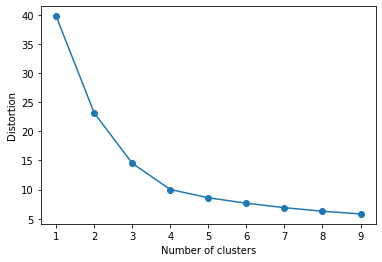

In [22]:
#choosing K using elbow method
def k_mean( df, kclusters = 5):
  kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df)   # run k-means clustering
  return kmeans.labels_, kmeans.inertia_

distortions = []
for k in range(1,10):
  _ , sum_dist= k_mean(HK_grouped.drop('neighborhood',1),kclusters = k)
  distortions.append(sum_dist)

# elbow plot
plt.plot(range(1, 10), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()


In [23]:
k = 4     #according to the elbow plot
cluster_labels , _= k_mean(HK_grouped.drop('neighborhood',1),kclusters = k)
HK_grouped_sorted['cluster_labels'] = cluster_labels
#reorder the df
column_list = HK_grouped_sorted.columns.to_list()
old_idx = column_list.index('cluster_labels')
column_list.insert(1, column_list.pop(old_idx))
HK_grouped_sorted = HK_grouped_sorted[column_list]
HK_grouped_sorted

,neighborhood,cluster_labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,A Kung Ngam,1,food,parks_outdoors,travel,arts_entertainment,Toy / Game Store,Discount Store,Farmers Market,Grocery Store,Market,Wine Shop
1,Aberdeen,0,food,parks_outdoors,travel,Shopping Mall,Athletics & Sports,Jewelry Store,Accessories Store,Clothing Store,Convenience Store,Electronics Store
2,Aldrich Bay,1,food,parks_outdoors,travel,arts_entertainment,Toy / Game Store,Discount Store,Farmers Market,Grocery Store,Shopping Mall,Market
3,Allway,0,food,travel,Supermarket,Shopping Mall,Gaming Cafe,Grocery Store,Pharmacy,Recreation Center,Sporting Goods Shop,Sports Club
4,Ap Lei Chau,1,food,travel,parks_outdoors,Accessories Store,Convenience Store,Furniture / Home Store,Shopping Mall,Supermarket,Clothing Store,Fish Market
...,...,...,...,...,...,...,...,...,...,...,...,...
360,Yuen Long Centre,1,food,travel,Shopping Mall,arts_entertainment,Market,parks_outdoors,Supermarket,Bookstore,building,Furniture / Home Store
361,Yuen Lung,1,food,travel,Shopping Mall,Market,arts_entertainment,building,Bank,Supermarket,Bookstore,Music Store
362,Yuet Wah,1,food,travel,building,Shopping Mall,parks_outdoors,Supermarket,Clothing Store,Convenience Store,Department Store,Electronics Store
363,Yuet Wu,0,food,travel,parks_outdoors,Shopping Mall,arts_entertainment,Athletics & Sports,Furniture / Home Store,Electronics Store,Farmers Market,Fish Market


####K-mean labels' meaning

After examining each cluster, the categories of each labels are as following:  
0: city with more hotels  
1: city with more shopping mall  
2: in between countryside city, with more hotels, café, farmer markets  
3: countryside with mostly park


In [24]:
HK_grouped_sorted[HK_grouped_sorted['cluster_labels']==0]

,neighborhood,cluster_labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Aberdeen,0,food,parks_outdoors,travel,Shopping Mall,Athletics & Sports,Jewelry Store,Accessories Store,Clothing Store,Convenience Store,Electronics Store
3,Allway,0,food,travel,Supermarket,Shopping Mall,Gaming Cafe,Grocery Store,Pharmacy,Recreation Center,Sporting Goods Shop,Sports Club
5,Ap Lei Chau Estate,0,food,travel,parks_outdoors,Shopping Mall,Accessories Store,Convenience Store,Furniture / Home Store,Clothing Store,Fish Market,Grocery Store
6,Bays Area,0,arts_entertainment,parks_outdoors,food,building,travel,Furniture / Home Store,Electronics Store,Farmers Market,Fish Market,Flea Market
11,Butterfly,0,food,travel,parks_outdoors,Shopping Mall,arts_entertainment,Athletics & Sports,Supermarket,Furniture / Home Store,Electronics Store,Farmers Market
...,...,...,...,...,...,...,...,...,...,...,...,...
343,Wu King,0,food,travel,Shopping Mall,Market,Sports Club,parks_outdoors,Convenience Store,education,Electronics Store,Farmers Market
346,Yat Tung Estate,0,food,travel,Clothing Store,Sporting Goods Shop,Convenience Store,Pharmacy,Shopping Mall,Market,Shop & Service,Lingerie Store
347,Yau Lai,0,food,travel,arts_entertainment,parks_outdoors,Shopping Mall,Market,building,Convenience Store,Grocery Store,Supermarket
363,Yuet Wu,0,food,travel,parks_outdoors,Shopping Mall,arts_entertainment,Athletics & Sports,Furniture / Home Store,Electronics Store,Farmers Market,Fish Market


In [25]:
HK_grouped_sorted[HK_grouped_sorted['cluster_labels']==1]

,neighborhood,cluster_labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,A Kung Ngam,1,food,parks_outdoors,travel,arts_entertainment,Toy / Game Store,Discount Store,Farmers Market,Grocery Store,Market,Wine Shop
2,Aldrich Bay,1,food,parks_outdoors,travel,arts_entertainment,Toy / Game Store,Discount Store,Farmers Market,Grocery Store,Shopping Mall,Market
4,Ap Lei Chau,1,food,travel,parks_outdoors,Accessories Store,Convenience Store,Furniture / Home Store,Shopping Mall,Supermarket,Clothing Store,Fish Market
7,Belcher,1,food,parks_outdoors,nightlife,travel,Supermarket,Furniture / Home Store,building,Liquor Store,Spa,Grocery Store
8,Bik Woo,1,food,Convenience Store,travel,Shopping Mall,building,Pharmacy,Athletics & Sports,Bookstore,parks_outdoors,Recreation Center
...,...,...,...,...,...,...,...,...,...,...,...,...
358,Yu Yan,1,food,Convenience Store,travel,Shopping Mall,building,Pharmacy,Athletics & Sports,Bookstore,parks_outdoors,Recreation Center
359,Yue Shing,1,food,travel,Clothing Store,Shopping Mall,Electronics Store,arts_entertainment,Furniture / Home Store,Supermarket,Boutique,Department Store
360,Yuen Long Centre,1,food,travel,Shopping Mall,arts_entertainment,Market,parks_outdoors,Supermarket,Bookstore,building,Furniture / Home Store
361,Yuen Lung,1,food,travel,Shopping Mall,Market,arts_entertainment,building,Bank,Supermarket,Bookstore,Music Store


In [26]:
HK_grouped_sorted[HK_grouped_sorted['cluster_labels']==2]

,neighborhood,cluster_labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
31,Ching King,2,travel,Gaming Cafe,Electronics Store,Farmers Market,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Fruit & Vegetable Store,Furniture / Home Store
46,Chung Pak,2,travel,Gaming Cafe,Electronics Store,Farmers Market,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Fruit & Vegetable Store,Furniture / Home Store
49,Chung Wah,2,travel,Gaming Cafe,Electronics Store,Farmers Market,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Fruit & Vegetable Store,Furniture / Home Store
69,Fu Nam,2,travel,Grocery Store,Gaming Cafe,Electronics Store,Farmers Market,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Fruit & Vegetable Store
73,Fu Yan,2,travel,Gaming Cafe,Electronics Store,Farmers Market,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Fruit & Vegetable Store,Furniture / Home Store
205,Pek Long,2,travel,Gaming Cafe,Electronics Store,Farmers Market,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Fruit & Vegetable Store,Furniture / Home Store
257,Shui Oi,2,travel,Gaming Cafe,Electronics Store,Farmers Market,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Fruit & Vegetable Store,Furniture / Home Store
258,Shui Pin,2,travel,Gaming Cafe,Electronics Store,Farmers Market,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Fruit & Vegetable Store,Furniture / Home Store
259,Shui Wah,2,travel,Gaming Cafe,Electronics Store,Farmers Market,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Fruit & Vegetable Store,Furniture / Home Store
313,Tsz Yau,2,travel,Gaming Cafe,Electronics Store,Farmers Market,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Fruit & Vegetable Store,Furniture / Home Store


In [27]:
HK_grouped_sorted[HK_grouped_sorted['cluster_labels']==3]

,neighborhood,cluster_labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
48,Chung Ting,3,parks_outdoors,food,travel,Accessories Store,Arts & Crafts Store,Farmers Market,Fish Market,Flea Market,Flower Shop,Food & Drink Shop
67,Fu Kwan,3,parks_outdoors,Gas Station,Farmers Market,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe
101,Hoi Bun,3,parks_outdoors,food,travel,arts_entertainment,Gaming Cafe,Electronics Store,Farmers Market,Fish Market,Flea Market,Flower Shop
138,Kwan Po,3,parks_outdoors,Gas Station,Farmers Market,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe
154,Lamma and Po Toi,3,parks_outdoors,Gas Station,Farmers Market,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe
185,Mount Parker,3,parks_outdoors,Gas Station,Farmers Market,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe
206,Peng Chau and Hei Ling Chau,3,parks_outdoors,Gas Station,Farmers Market,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe
255,Shing Mun,3,parks_outdoors,Gas Station,Farmers Market,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe
268,Stanley and Shek O,3,parks_outdoors,arts_entertainment,Gaming Cafe,Electronics Store,Farmers Market,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Fruit & Vegetable Store
280,Tai Po Kau,3,parks_outdoors,food,Gaming Cafe,Electronics Store,Farmers Market,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Fruit & Vegetable Store


##4. Results

###4.1 Population Table

The highest population is Sha Tin, second is Kwun Tong, third is Yuen Long.


In [28]:
poplution_df.sort_values(by ='population', ascending=False)

,neighborhood,population
15,Sha Tin,659794
8,Kwun Tong,648541
12,Yuen Long,614178
2,Eastern,555034
9,Kwai Tsing,520572
11,Tuen Mun,489299
16,Sai Kung,461864
7,Wong Tai Sin,425235
6,Kowloon City,418732
5,Sham Shui Po,405869


###4.2 Choropleth map

Below is the final map showing population as choropleth, neighbourhood as points where label 0: red, label 1: purple,label 2: blue, label 3: green.

As shown in the map, Yuen Long District is high in population but less shops. Wang Chau is even in between countryside and city which have not much restaurants.

####population & venues dataframe

In [29]:
combine_df = neighborhood_df.merge(HK_grouped_sorted.filter(['neighborhood','cluster_labels'],axis = 1), on = 'neighborhood')
combine_df

,district,neighborhood,latitude,longitude,cluster_labels
0,Central and Western,Central,22.281322,114.160258,0
1,Central and Western,Mid Levels,22.282405,114.145809,1
2,Central and Western,Castle Road,22.281680,114.147808,1
3,Central and Western,Peak,22.269917,114.150667,0
4,Central and Western,HKU,22.283976,114.135507,1
...,...,...,...,...,...
361,Islands,Tung Chung,22.289257,113.941491,0
362,Islands,Discovery Bay,22.297369,114.016528,0
363,Islands,Peng Chau and Hei Ling Chau,22.230076,113.986785,3
364,Islands,Lamma and Po Toi,22.230076,113.986785,3


####choropleth-of-Hong-Kong

In [0]:
# Make functions to facilitate the generation of choropleth, tooltip. 

def make_choropleth(data,name,col,**kargs):
    '''create choropleth from the passed in data'''
    choropleth = folium.Choropleth(
                    name = name,
                    geo_data = geo_json_data,
                    data = data,
                    columns = ["name", col],
                    key_on = "feature.properties.name",
                    fill_opacity = 0.5,
                    line_weight = 1.5,
                    highlight = True,
                    show = False,**kargs)
    return choropleth

def make_tooltip(display,style,col=None):
    '''create tooltip for district name and additional column if col is not None'''
    if col is not None:
        tooltip = folium.features.GeoJsonTooltip(["name",col],
                                             display,
                                             labels=True)
        return  folium.GeoJson(choropleth_df[["name","geometry",col]],
                                tooltip=tooltip,
                                style_function = lambda x: style)
    else:
        tooltip = folium.features.GeoJsonTooltip(["name"],display,labels=False)
        return folium.GeoJson(choropleth_df[["name","geometry"]],tooltip=tooltip,
                              style_function = lambda x: style)

In [31]:
# Path of map data
geo_path = "/content/drive/My Drive/capstone project/districts.geojson"
geo_json_data = json.load(open(geo_path))
gpf = gpd.read_file(geo_path)
#gpf.rename(columns = {'name':'neighborhood'}, inplace)

# merge the data into a single DataFrame
choropleth_df = gpf.merge(poplution_df,"inner",left_on='name',right_on='neighborhood')[['name','geometry','population']]
choropleth_df

,name,geometry,population
0,North,"POLYGON ((114.08546 22.53301, 114.08074 22.531...",315270
1,Tai Po,"POLYGON ((114.12799 22.46676, 114.12752 22.466...",303926
2,Yuen Long,"POLYGON ((114.12555 22.41603, 114.12482 22.416...",614178
3,Tuen Mun,"POLYGON ((113.87295 22.43102, 113.86909 22.428...",489299
4,Tsuen Wan,"POLYGON ((113.99461 22.32483, 113.99448 22.314...",318916
5,Sha Tin,"POLYGON ((114.22927 22.43864, 114.20696 22.426...",659794
6,Sham Shui Po,"POLYGON ((114.14657 22.34424, 114.14663 22.342...",405869
7,Kwai Tsing,"POLYGON ((114.07272 22.31272, 114.10937 22.312...",520572
8,Islands,"POLYGON ((113.86557 22.32388, 113.84703 22.273...",156801
9,Southern,"POLYGON ((114.30888 22.19249, 114.26090 22.246...",274994


####create map

In [32]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)
# Display and style for tooltip
display = ["District","Population"]
style = {'fillColor': '#00000000','color': '#00000000'}
base_style = {'color':'#0C090A','fillColor':'#00000000'}

# Create the base tooltip to display the boundary and name of districts
base_tooltip = make_tooltip(["Neighborhood"],base_style,col=None)
base_tooltip.control = False
base_tooltip.add_to(map_clusters)


# Parameters for population choropleth (Name, column, Legend name)
population = ("Population","population","population")
choropleth_layers = [population]
poplution_df = choropleth_df[["name","population"]]
for layer in choropleth_layers:
    tooltip = make_tooltip(display,style,col=layer[1])
    choropleth = make_choropleth(poplution_df,layer[0],layer[1],fill_color="PuRd",legend_name=layer[2])
    choropleth.add_child(tooltip)
    choropleth.add_to(map_clusters)
folium.LayerControl(collapsed=False).add_to(map_clusters)


# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(combine_df['latitude'], combine_df['longitude'], combine_df['neighborhood'], combine_df['cluster_labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

##5. Discussion

The definition of neighbourhoods based on the gov population result is too fine, which may lead to fail in generating the geographic coordinate through geocoding API. That's why large work on data cleaning was done in this project. This could be improved if a geocoding API with more accurate and detailed information about HK is found, such as Google Maps Geocoding API (but it is not free to use).

The choropleth map can be more fine defined, as there are official source about the neighbourhoods boundaries, but takes time to turn it into suitable format.

Note that the population data are showing where Hong Kong people lives, but most of the HK people are working far away from their home. In other words, for other kind of business, such as fitness studio which need a high stream of people, may need to consider data other than population in districts. Such as rate of public transport usage in districts which can simulate stream rate of people.


##6. Conclusion
According to the final map shown in 4.Results section, Yuen Long may have a high potential in further development and hence it is a good location to start residential related business, such as restaurants or stores.

As a result, there is an increasing trend of people coming into HK. For this reason, people can achieve better outcomes through their access to platforms where such information is provided.

Not only for investors but also city managers can manage the city more regularly by using similar data analysis types or platforms.